# An analysis of the State of the Union speeches - Part 1

In [1]:
%load_ext watermark

In [5]:
#add watermark to save the package versions.
%watermark -v -m -p scipy,pandas,matplotlib,seaborn,numpy,nltk,sklearn,watermark -g

CPython 3.6.3
IPython 6.1.0

scipy 0.19.1
pandas 0.20.3
matplotlib 2.0.2
seaborn 0.8.0
numpy 1.13.1
nltk 3.2.4
sklearn 0.19.1
watermark 1.5.0

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 16.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
Git hash   : 30d3590e4d1382e395205ca764f961cbb7291766


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

This is a "hollowed out" version of my complete analysis, leaving you a few results to check your progress:

In [2]:
from io import StringIO
with open('data/stateoftheunion1790-2017.txt') as f:
    txt=f.read()

#saving the dataframe for address from CONTENT.
index = ['president', 'title', 'date','']
content = pd.read_csv(StringIO(txt), names = index, 
                   skiprows = 10, nrows=227, sep = ',', parse_dates=[[2,3]])

addresses = pd.DataFrame({'president': content['president'], 'title': content['title'], 'date' : content['date_']})
addresses = addresses[['president','title','date']]

In [3]:
# Addresses is a dataframe with all the basic data for the addresses:
addresses.head()

,president,title,date
0,George Washington,State of the Union Address,1790-01-08
1,George Washington,State of the Union Address,1790-12-08
2,George Washington,State of the Union Address,1791-10-25
3,George Washington,State of the Union Address,1792-11-06
4,George Washington,State of the Union Address,1793-12-03


Let's take a first look at a high-level summary of what we have so far:

In [4]:
# Describe the presidents data
addresses['president'].describe()

count                         227
unique                         42
top         Franklin D. Roosevelt
freq                           12
Name: president, dtype: object

Let's find the dates of the first and last address, and how much time has passed between those:

In [5]:
# This is roughly the number of years between the first and last address:
pd.Timedelta(max(addresses['date']) - min(addresses['date'])).days / 365.25

227.13210130047912

Let's see during which months are the speeches most frequently delivered:

In [6]:
# This is a count of the number of addresses delivered on any given month
from datetime import *
import calendar

#month = [calendar.month_name[i] for i in range(1,12)]
acounts = addresses['date'].groupby([addresses.date.dt.month]).count().reindex([i for i in range(1,13)], fill_value=0)
acounts = acounts.rename('Address counts')
acounts = acounts.rename(lambda x: calendar.month_name[x])
del acounts.index.name
acounts 

January       75
February      12
March          0
April          0
May            0
June           0
July           0
August         0
September      2
October        3
November      11
December     124
Name: Address counts, dtype: int64

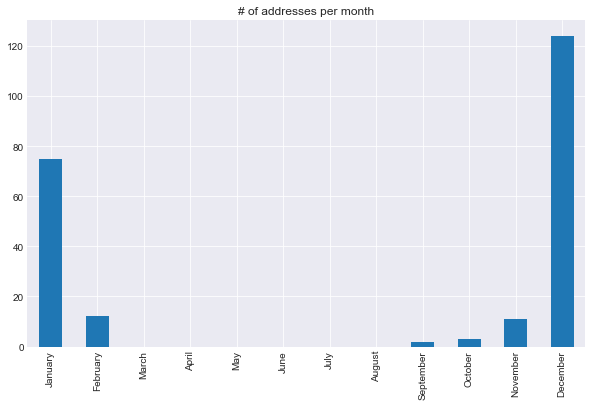

In [7]:
# And this is a plot of the speech number sorted by month:
acounts.plot(kind='bar', grid=True, title ="# of addresses per month")
plt.savefig('fig/addresses_month.png');

Let's look at the distribution of differences between successive speeches:

Where is the largest gap? We can ask the `ddiff` series for its location:

In [8]:
# this is the index of the largest gap:
dates = addresses['date']
ddiff = dates.diff()
dgap = ddiff.idxmax()
dgap

104

Let's look at the dates around this index:

In [9]:
dates[dgap-2 : dgap+2]

102   1891-12-09
103   1892-12-06
104   1897-12-06
105   1898-12-05
Name: date, dtype: datetime64[ns]

As well as a plot of these times:

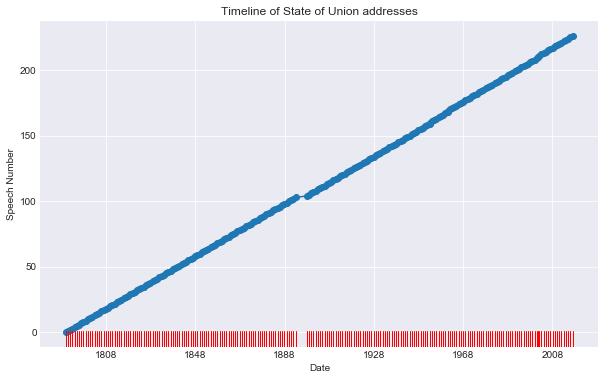

In [10]:
# A plot of the times, along with 'rug' markers on the x axis.
f, ax = plt.subplots()
plt.grid()
ax.scatter(dates.values, dates.index)
ax.set_title('Timeline of State of Union addresses')
ax.set_xlabel('Date')
ax.set_ylabel('Speech Number')
ax.plot(dates.values, dates.index)
sns.rugplot(dates.values,ax = ax,color = 'r')
f.savefig('fig/timeline.png')

What happened at that gap?

#### <span style="color:blue">The data from the original txt file between year 1892-1897 is missing.</span>


## Intermediate results

Let's save some intermediate results for further analysis. This lets us work on subsequent notebooks  without rerunning this one.  We use the Pandas HDF5 support for efficient and type-safe serialization of data frames, and the python builtin [shelve](https://docs.python.org/3/library/shelve.html) module for simple Python variables.  We'll create for each notebook variable stores with the notebook number, one for dataframes (`df1.h5`, `df2.h5`, etc.) and one for python variables (`vars1.db`, `vars2.db`, etc.).  These will all go into the `results/` subdirectory.

In [12]:
speeches = str(txt).split('***')[1:]
addresses.to_hdf('results/df1.h5', 'addresses')
with shelve.open('results/vars1') as db:
    db['speeches'] = speeches